In [1]:
# For TensorFlow version 2.12 or earlier

# Command Line Tools
# sudo rm -rf /Library/Developer/CommandLineTools
# xcode-select --install

# Create conda environment
# conda create -n tensorenv python=3.10
# conda activate tensorenv

# And then Tensorflow dependencies
# conda install apple::tensorflow-deps
# conda install notebook -y

# pip install pandas matplotlib scikit-learn scipy plotly --upgrade
# pip install tensorflow-macos==2.12 numpy==1.23.5 tensorflow-metal==0.8.0 --force-reinstall

In [2]:
# # Instantiate an optimizer.
# optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# # Instantiate a loss function.
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # Prepare the training dataset.
# batch_size = 32


# # Get a fresh model
# model = get_model()

# # Instantiate an optimizer to train the model.
# optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# # Instantiate a loss function.
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # Prepare the metrics.
# train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
# val_acc_metric = keras.metrics.SparseCategoricalAccuracy()



In [3]:
# epochs = 3
# for epoch in range(epochs):
#     print(f"\nStart of epoch {epoch}")

#     # Iterate over the batches of the dataset.
#     for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
#         # Open a GradientTape to record the operations run
#         # during the forward pass, which enables auto-differentiation.
#         with tf.GradientTape() as tape:
#             # Run the forward pass of the layer.
#             # The operations that the layer applies
#             # to its inputs are going to be recorded
#             # on the GradientTape.
#             logits = model(x_batch_train, training=True)  # Logits for this minibatch

#             # Compute the loss value for this minibatch.
#             loss_value = loss_fn(y_batch_train, logits)

#         # Use the gradient tape to automatically retrieve
#         # the gradients of the trainable variables with respect to the loss.
#         grads = tape.gradient(loss_value, model.trainable_weights)

#         # Run one step of gradient descent by updating
#         # the value of the variables to minimize the loss.
#         optimizer.apply(grads, model.trainable_weights)

#         # Log every 100 batches.
#         if step % 100 == 0:
#             print(
#                 f"Training loss (for 1 batch) at step {step}: {float(loss_value):.4f}"
#             )
#             print(f"Seen so far: {(step + 1) * batch_size} samples")


In [4]:
# conda install kagglehub

In [5]:
# import kagglehub

# # Download the latest version.
# kagglehub.competition_download('home-credit-default-risk')

# # # Download a single file.
# # kagglehub.competition_download('home-credit-default-risk', path='train.csv')

# # # Download a competition or file, even if previously downloaded to cache. 
# # kagglehub.competition_download('home-credit-default-risk', force_download=True)

# # '/Users/bharat/.cache/kagglehub/competitions/home-credit-default-risk'


In [6]:
src_path = "../src/"
lib_path = "../lib/"
input_path = "../../kaggle/input/home-credit-default-risk/"

In [ ]:
import platform
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

pd.set_option("display.max_columns", 200)
tf.random.set_seed(42)
set_config(transform_output="pandas")

sys.path.insert(0, src_path)
data_processing = joblib.load(lib_path + "data_processing.joblib")
preprocessor = data_processing["preprocessor"]
non_co_cols = data_processing["non_co_cols"]
merged_application_test = data_processing["merged_application_train"]
from threshold_tuner import ClassificationThresholdTuner
del sys.path[0]

In [8]:
def plot_history(history):
    for metric in history.history.keys():
        if not metric.startswith("val"):
            plt.plot(history.history[metric], label=metric)
            if f"val_{metric}" in history.history.keys():
                plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
            plt.title(metric)
            plt.legend()
            plt.show()

In [9]:
print(f"{platform.platform()}")
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
print(f"SciPy {scipy.__version__}")
print()
print(f"TensorFlow {tf.__version__}")
print(f"Keras {keras.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
tf.config.list_physical_devices('GPU')

macOS-15.4.1-arm64-arm-64bit
Python 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]
NumPy 1.23.5
Pandas 2.2.3
Scikit-Learn 1.6.1
SciPy 1.15.2

TensorFlow 2.12.0
Keras 2.12.0
GPU is available
Number of GPUs Available:  1
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 8.00 GB

tf.Tensor(-325.82767, shape=(), dtype=float32)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# # Import operation in python script for training
# import tensorflow as tf
# zero_out_module = tf.load_op_library('./zero_out.so')
# print(zero_out_module.zero_out([[1, 2], [3, 4]]).numpy())

In [11]:
# separate data
X = merged_application_test.drop(columns=["TARGET", "SK_ID_CURR"])
y = merged_application_test["TARGET"].copy()

In [12]:
# split data 80/10/10 for training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, test_size=0.5, random_state=42)
# transform data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)
# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
X_train = X_train.drop(columns=non_co_cols)
X_val = X_val.drop(columns=non_co_cols)
X_test = X_test.drop(columns=non_co_cols)
# scale remaining data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
from keras.utils import to_categorical

# create y arrays for multiclass modeling
y_array_train = to_categorical(y_train)
y_array_val = to_categorical(y_val)
y_array_test = to_categorical(y_test)

In [ ]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
from keras.metrics import AUC
# from keras.optimizers.legacy import Adam


# Binary Classification Scenario 1
# --------------------------------
# If your model outputs a softmax vector (probabilities for each class),
# your target variable should be one-hot encoded.
# You can use tf.keras.utils.to_categorical to convert integer labels to one-hot vectors.
# array([[0., 1.],
#        [1., 0.],
#        [1., 0.],
#        ...,
#        [1., 0.],
#        [0., 1.],
#        [1., 0.]], dtype=float32)
# For multi-class classification with one-hot encoded targets (softmax activation), use categorical_crossentropy.
def create_model_1():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer
    model.add(Dense(4, activation="relu"))  # Hidden layer 1
    model.add(Dense(2, activation="softmax"))  # Output layer

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc")],
    )
    return model


model_1 = create_model_1()

history_1 = model_1.fit(
    X_train,
    y_array_train,
    validation_data=(X_val, y_array_val),
    epochs=16,
    batch_size=64,
)

# history = model.fit(
#     x_train,
#     y_train,
#     batch_size=64,
#     epochs=2,
#     # We pass some validation for
#     # monitoring validation loss and metrics
#     # at the end of each epoch
#     validation_data=(x_val, y_val),
# )

# model.compile(
#     optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
#     loss=keras.losses.SparseCategoricalCrossentropy(),
#     metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )

Epoch 1/50


2025-04-20 22:53:54.947592: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


961/961 [==============================] - 14s 14ms/step - loss: 0.2783 - accuracy: 0.9164 - auc: 0.9385 - val_loss: 0.2605 - val_accuracy: 0.9189 - val_auc: 0.9508
Epoch 2/50
961/961 [==============================] - 13s 14ms/step - loss: 0.2554 - accuracy: 0.9192 - auc: 0.9529 - val_loss: 0.2534 - val_accuracy: 0.9189 - val_auc: 0.9540
Epoch 3/50
961/961 [==============================] - 13s 14ms/step - loss: 0.2527 - accuracy: 0.9192 - auc: 0.9544 - val_loss: 0.2521 - val_accuracy: 0.9189 - val_auc: 0.9546
Epoch 4/50
961/961 [==============================] - 13s 14ms/step - loss: 0.2521 - accuracy: 0.9191 - auc: 0.9546 - val_loss: 0.2527 - val_accuracy: 0.9187 - val_auc: 0.9547
Epoch 5/50
961/961 [==============================] - 13s 14ms/step - loss: 0.2517 - accuracy: 0.9191 - auc: 0.9549 - val_loss: 0.2514 - val_accuracy: 0.9188 - val_auc: 0.9550
Epoch 6/50
961/961 [==============================] - 14s 14ms/step - loss: 0.2517 - accuracy: 0.9191 - auc: 0.9549 - val_loss: 0.2

Many built-in optimizers, losses, and metrics are available
In general, you won't have to create your own losses, metrics, or optimizers from scratch, because what you need is likely to be already part of the Keras API:

Optimizers:

- SGD() (with or without momentum)
- RMSprop()
- Adam()
- etc.  


Losses:

- MeanSquaredError()
- KLDivergence()
- CosineSimilarity()
- etc.


Metrics:

- AUC()
- Precision()
- Recall()
- etc.

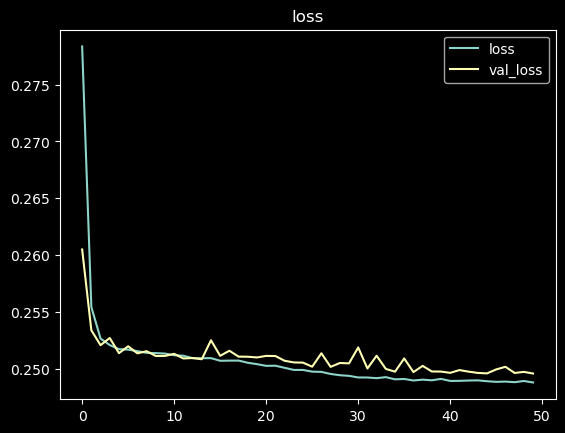

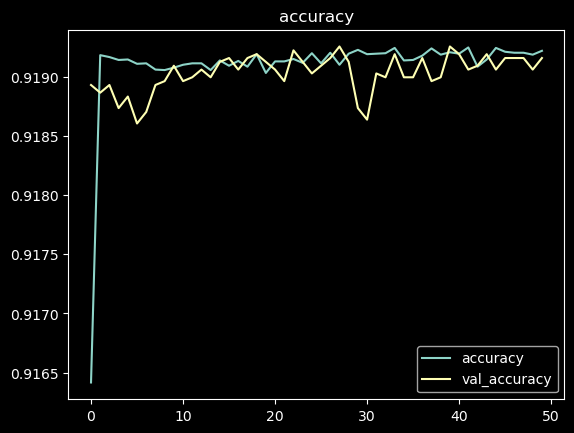

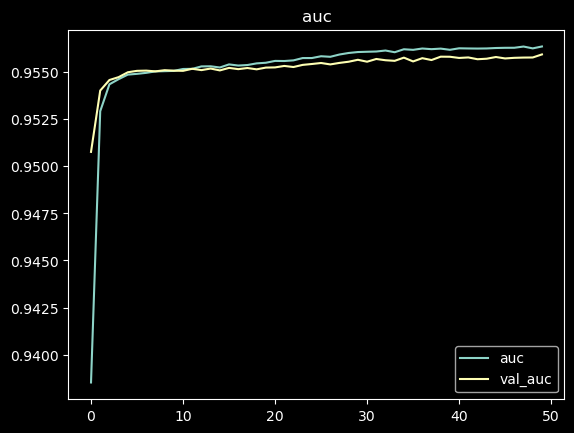

In [15]:
plot_history(history_1)

961/961 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28295
           1       0.42      0.01      0.03      2457

    accuracy                           0.92     30752
   macro avg       0.67      0.51      0.49     30752
weighted avg       0.88      0.92      0.88     30752



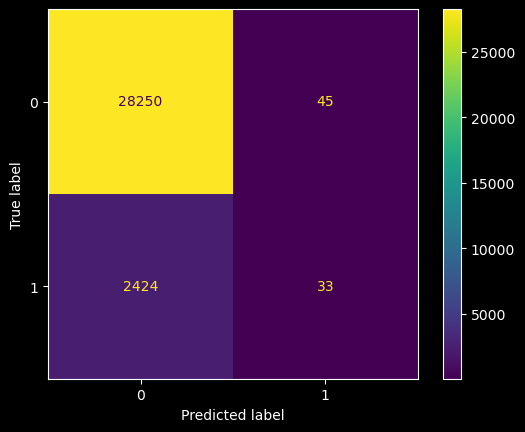

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

y_pred = model_1.predict(X_test)
# y_array_pred = np.argmax(y_array_pred, axis=1)
# y_array_test = pd.DataFrame(y_array_test)

y_pred_flat = np.argmax(y_pred, axis=1)


print(classification_report(y_true=y_test, y_pred=y_pred_flat, zero_division=np.nan))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred_flat);

In [21]:
model_1.evaluate(X_test, y_array_test)

961/961 [==============================] - 11s 12ms/step - loss: 0.2487 - accuracy: 0.9197 - auc: 0.9567


[0.24868594110012054, 0.9197125434875488, 0.9566718339920044]

In [22]:
model_1.metrics_names

['loss', 'accuracy', 'auc']

In [ ]:
# tensorboard --logdir=/full_path_to_your_logs

In [ ]:
# keras.callbacks.TensorBoard(
#     log_dir="/full_path_to_your_logs",
#     histogram_freq=0,  # How often to log histogram visualizations
#     embeddings_freq=0,  # How often to log embedding visualizations
#     update_freq="epoch",
# )  # How often to write logs (default: once per epoch)

In [23]:
# Binary Classification Scenario 2
# --------------------------------
# If you're doing binary classification, ensure your final layer
# has one neuron and uses a sigmoid activation function.
# 0         1
# 1         0
# 2         0
# 3         0
# 4         0
#          ..
# 307506    0
# 307507    0
# 307508    0
# 307509    1
# 307510    0
# Name: TARGET, Length: 307511, dtype: int64
# For binary classification with a single output neuron (sigmoid activation), use binary_crossentropy.
def create_model_2():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer
    model.add(Dense(64, activation="relu"))  # Hidden layer 1
    model.add(Dense(32, activation="relu"))  # Hidden layer 2
    model.add(Dense(16, activation="relu"))  # Hidden layer 3
    model.add(Dense(16, activation="relu"))  # Hidden layer 4
    model.add(Dense(1, activation="sigmoid"))  # Output layer

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", AUC(name="auc")],
    )
    return model


model_2 = create_model_2()
history_2 = model_2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
)


Epoch 1/10
3844/3844 [==============================] - 42s 11ms/step - loss: 0.2576 - accuracy: 0.9191 - auc: 0.7178 - val_loss: 0.2536 - val_accuracy: 0.9190 - val_auc: 0.7394
Epoch 2/10
3844/3844 [==============================] - 38s 10ms/step - loss: 0.2527 - accuracy: 0.9192 - auc: 0.7360 - val_loss: 0.2524 - val_accuracy: 0.9190 - val_auc: 0.7388
Epoch 3/10
3844/3844 [==============================] - 39s 10ms/step - loss: 0.2517 - accuracy: 0.9192 - auc: 0.7395 - val_loss: 0.2511 - val_accuracy: 0.9189 - val_auc: 0.7428
Epoch 4/10
3844/3844 [==============================] - 39s 10ms/step - loss: 0.2513 - accuracy: 0.9192 - auc: 0.7410 - val_loss: 0.2547 - val_accuracy: 0.9190 - val_auc: 0.7400
Epoch 5/10
3844/3844 [==============================] - 39s 10ms/step - loss: 0.2507 - accuracy: 0.9193 - auc: 0.7435 - val_loss: 0.2520 - val_accuracy: 0.9190 - val_auc: 0.7420
Epoch 6/10
3844/3844 [==============================] - 38s 10ms/step - loss: 0.2501 - accuracy: 0.9192 - auc:

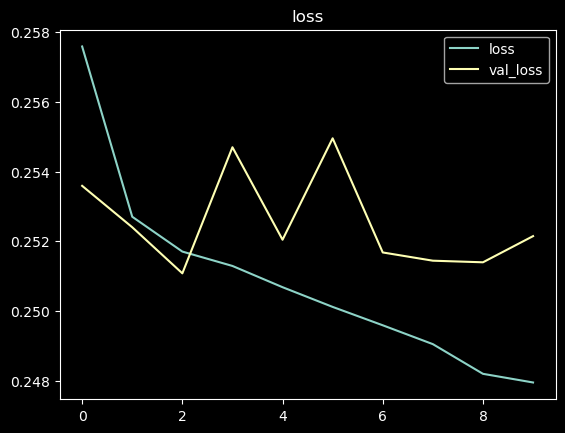

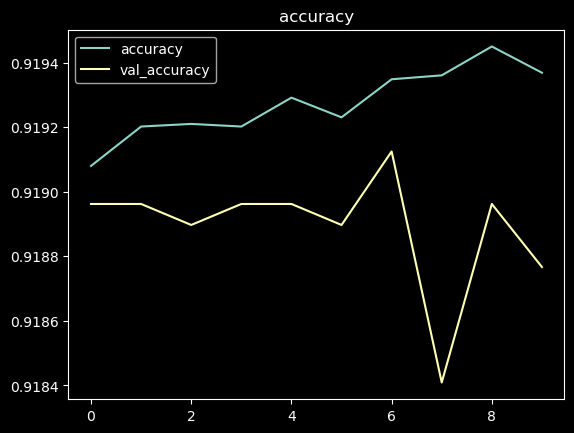

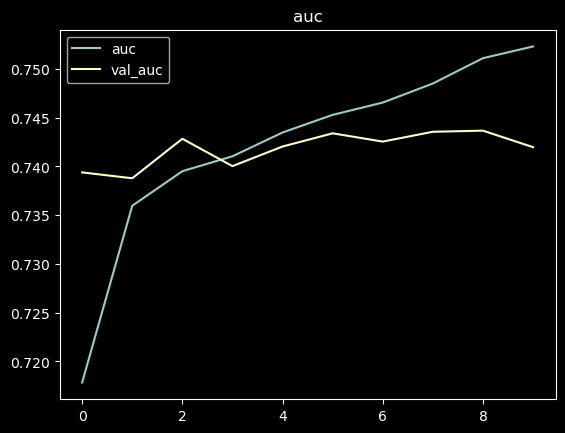

In [24]:
plot_history(history_2)

In [25]:
model_2.evaluate(X_test, y_test, batch_size=256)

121/121 [==============================] - 1s 9ms/step - loss: 0.2509 - accuracy: 0.9197 - auc: 0.7409


[0.2508954703807831, 0.9196799993515015, 0.7408645749092102]

In [35]:
y_pred = model_2.predict(X_test)
# y_array_pred = np.argmax(y_array_pred, axis=1)
# y_array_test = pd.DataFrame(y_array_test)

y_pred_flat = np.argmax(y_pred, axis=1)


961/961 [==============================] - 2s 2ms/step


In [ ]:
# y_pred = pd.DataFrame(
#     {"zero": 0, "pred": np.nan}, index=range(len(preds))
# )

# for i in range(len(preds)):
#     y_pred.iloc[i, 1] = preds[i][0]

# y_pred

,zero,pred
0,0,0.134091
1,0,0.061141
2,0,0.082700
3,0,0.047880
4,0,0.138071
...,...,...
30747,0,0.229318
30748,0,0.102233
30749,0,0.254785
30750,0,0.286956


In [ ]:
# # y_pred = (y_pred>0.25) # It will evaluate the logical expression y_pred>0.25 and return True or False 
# model_2_pred = pd.DataFrame(columns=["Pred"], index=y_test.index)
# model_2_pred['Pred'] = np.where(y_pred > 0.50, 1, 0)

# model_2_pred.tail(10)


,Pred
280076,0
288818,0
228578,0
16278,0
29823,0
68298,0
34458,0
1730,0
61780,0
65706,0


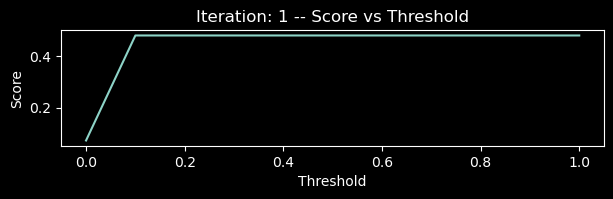

/Users/bharat/Documents/GitHub/neural-home-credit-default-risk/kaggle/working/../src/threshold_tuner.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


,Metric,0,1,Macro
0,Precision,0.920103,0.0,0.460051
0,Recall,1.000000,0.0,0.500000
0,F1,0.958389,0.0,0.479195


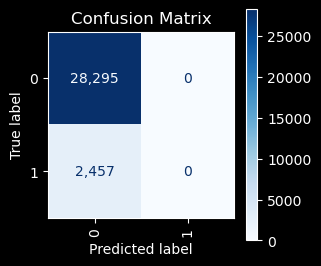

,Metric,Score
0,Brier Score,0.079897
1,AUROC,0.500000


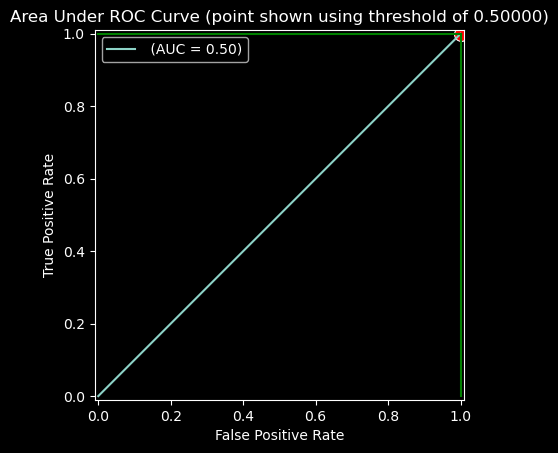

KeyboardInterrupt: 

In [36]:
tuner_2 = ClassificationThresholdTuner()


from sklearn.metrics import f1_score

best_threshold_2 = tuner_2.tune_threshold(
    y_true=y_test, 
    target_classes=[0,1],
    y_pred_proba=y_pred_flat,
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    max_iterations=5
)

tuner_2.print_stats_proba(
    y_true=y_test, 
    target_classes=[0,1], 
    y_pred_proba=y_pred_flat) 


tuned_pred_2 = tuner_2.get_predictions(
    target_classes=[0, 1],
    y_pred_proba=y_pred_flat,
    default_class=0,
    thresholds=best_threshold_2,
)
tuned_pred_2 = pd.Series(tuned_pred_2)
tuned_pred_2 = tuned_pred_2.astype(int)

In [39]:
y_test_flat = np.argmax(y_test, axis=0)

In [42]:
# print(classification_report(y_true=y_test, y_pred=tuned_pred_2))
print(classification_report(y_test, y_pred_flat, zero_division=np.nan))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28295
           1        nan      0.00      0.00      2457

    accuracy                           0.92     30752
   macro avg       0.92      0.50      0.48     30752
weighted avg       0.92      0.92      0.88     30752



In [43]:
# ConfusionMatrixDisplay.from_predictions(y_test, tuned_pred_2)
ConfusionMatrixDisplay.from_estimator(model_2, X_test, y_test_flat)

ValueError: ConfusionMatrixDisplay.from_estimator only supports classifiers

In [ ]:
from keras.callbacks import EarlyStopping
from keras.metrics import AUC



# Binary Classification Scenario 3
# --------------------------------
# If your model outputs a single value (e.g., a probability between 0 and 1 for binary classification),
# your target variable should be a single value (0 or 1).
# If you're doing multi-class classification, ensure your final layer has a number of neurons equal to the number of classes
# and uses a softmax activation function. Also ensure that your labels are properly one-hot encoded.
# For multi-class classification with integer targets, use sparse_categorical_crossentropy.
def create_model_3():
    model = Sequential()

    model.add(Input(shape=(X_train.shape[1],)))  # Input layer

    model.add(Dense(32, activation="relu"))  # Hidden layer 1
    model.add(Dropout(0.2))

    model.add(Dense(16, activation="relu"))  # Hidden layer 2
    model.add(Dropout(0.2))

    model.add(Dense(8, activation="relu"))  # Hidden layer 3
    model.add(Dropout(0.2))

    model.add(Dense(y_train.nunique(), activation="softmax"))  # Output layer

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", AUC(name="auc")]
    )

    return model


model_3 = create_model_3()
history_3 = model_3.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=256, callbacks=[EarlyStopping(patience=3, restore_best_weights=True,
    monitor="val_auc", mode="min")]
)

Epoch 1/50


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/engine/training.py", line 1055, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/engine/training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/metrics/confusion_metrics.py", line 1485, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/kerasenv/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 674, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 2) and (None, 1) are incompatible


In [ ]:
plot_history(history_3)

In [ ]:
from sklearn.metrics import roc_auc_score

# Make predictions on the validation set
y_pred_proba = model_3.predict(X_test)

# Calculate AUC
test_auc = roc_auc_score(y_test, y_pred_proba[:, 1])  # Assuming binary classification and probabilities for class 1

print(f"Validation AUC: {test_auc}")

In [ ]:
tuner_3 = ClassificationThresholdTuner()

tuner_3.print_stats_table(
    y_true=y_test,
    target_classes=[0, 1],
    y_pred_proba=y_pred_proba,
    num_ranges=len(y_test),
)

tuner_3.print_stats_proba(
    y_true=y_test, target_classes=[0, 1], y_pred_proba=y_pred_proba
)

tuner_3.plot_by_threshold(
    y_true=y_test, target_classes=[0, 1], y_pred_proba=y_pred_proba
)

best_threshold_3 = tuner_3.tune_threshold(
    y_true=y_test,
    target_classes=[0, 1],
    y_pred_proba=y_pred_proba,
    metric=f1_score,
    average="macro",
    higher_is_better=True,
    max_iterations=5,
)

tuned_pred_3 = tuner_3.get_predictions(
    target_classes=[0, 1],
    y_pred_proba=y_pred_proba,
    default_class=0,
    thresholds=best_threshold_3,
)
tuned_pred_3 = pd.Series(tuned_pred_3)
tuned_pred_3 = tuned_pred_3.astype(int)

print(
    classification_report(
        y_test,
        tuned_pred_3,
        zero_division=np.nan,
    )
)
ConfusionMatrixDisplay.from_predictions(y_test, tuned_pred_3)

## Import test data and preliminary merge

In [ ]:
test_data_file = "application_test.csv"
application_test = pd.read_csv(input_path + test_data_file)

bureau_loans_and_balances = pd.read_csv(lib_path + "bureau_loans_and_balances.csv")

installments_payments = pd.read_csv(input_path + "installments_payments.csv")
POS_CASH_balance = pd.read_csv(input_path + "POS_CASH_balance.csv")
credit_card_balance = pd.read_csv(input_path + "credit_card_balance.csv")

application_test = pd.merge(application_test, bureau_loans_and_balances, how="left", on="SK_ID_CURR")

idx = pd.DataFrame(application_test['SK_ID_CURR'])

## Processing

In [ ]:
# INSTALL steps
installments_payments.drop(columns="SK_ID_PREV", inplace=True)
installments_payments.columns = [col + "_INSTALL" for col in installments_payments.columns]
merge_INSTALL = pd.merge(idx, installments_payments, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_INSTALL")
merge_INSTALL.drop(columns="SK_ID_CURR_INSTALL", inplace=True)
merge_INSTALL = merge_INSTALL.sort_values(by="NUM_INSTALMENT_NUMBER_INSTALL", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# POS steps
POS_CASH_balance.drop(columns="SK_ID_PREV", inplace=True)
POS_CASH_balance.columns = [col + "_POS" for col in POS_CASH_balance.columns]
merge_POS = pd.merge(idx, POS_CASH_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_POS")
merge_POS.drop(columns="SK_ID_CURR_POS", inplace=True)
merge_POS = merge_POS.sort_values(by="MONTHS_BALANCE_POS", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# CC step
credit_card_balance.drop(columns="SK_ID_PREV", inplace=True)
credit_card_balance.columns = [col + "_CC" for col in credit_card_balance.columns]
merge_CC = pd.merge(idx, credit_card_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_CC")
merge_CC.drop(columns="SK_ID_CURR_CC", inplace=True)
merge_CC = merge_CC.sort_values(by="MONTHS_BALANCE_CC", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# Merge down filtered data
balances_and_payments = pd.merge(merge_INSTALL, merge_POS, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")
balances_and_payments = pd.merge(balances_and_payments, merge_CC, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")

# Drop object columns
# balances_and_payments.select_dtypes(include="object")
balances_and_payments.drop(labels=["NAME_CONTRACT_STATUS_POS", "NAME_CONTRACT_STATUS_CC"], axis=1, inplace=True)

# Merge down onto test file
application_test = pd.merge(application_test, balances_and_payments, how="left", on="SK_ID_CURR")

In [ ]:
# pop off index ids
ids = application_test.pop("SK_ID_CURR")

# transform data
application_test = preprocessor.transform(application_test)

# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
application_test.drop(columns=non_co_cols, inplace=True)


## Output

In [ ]:
# make predictions
preds = hgb_3.predict_proba(application_test)[:,1]

output = pd.DataFrame({"SK_ID_CURR": ids,
                       "TARGET": preds})

In [ ]:
output

## Export submission

In [ ]:
sample_submission_file = "sample_submission.csv"
sample_submission_df = pd.read_csv(input_path + sample_submission_file)
sample_submission_df["TARGET"] = preds
submission_path = "submissions/"
sample_submission_df.to_csv(submission_path + "02_hgb_3_kaggle.csv", index=False)
sample_submission_df.head()

# Save model for future use

In [ ]:
# # saving model to lib folder for future use
# to_save = {"model" : calibrated_clf}
# joblib_filename = "modelling.joblib"

# joblib.dump(to_save, src_path + joblib_filename)